 **Mini Project: Molecular Descriptors & Chemical Space Visualization**

Step 1. Install RDKit in Colab

In [1]:
# Install RDKit
!pip install rdkit pandas scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 17.5 MB/s eta 0:00:00


Step 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Step 3. Input Molecules (SMILES Strings)

 Example dataset (can replace with other molecules).

In [3]:
# Example SMILES list (Drug-like molecules)
smiles_list = [
    "CCO",                     # Ethanol
    "CC(=O)OC1=CC=CC=C1C(=O)O", # Aspirin
    "CCN1C=NC2=C1C(=O)N(C(=O)N2C)C", # Caffeine
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O", # Ibuprofen
    "CN1CCCC1C2=CN=CC=C2", # Nicotine
    "CC(C)NCC(O)COc1ccc2c(c1)OCO2"  # Propranolol
]
names = ["Ethanol", "Aspirin", "Caffeine", "Ibuprofen", "Nicotine", "Propranolol"]

# Create dataframe
data = pd.DataFrame({"Name": names, "SMILES": smiles_list})
data

,Name,SMILES
0,Ethanol,CCO
1,Aspirin,CC(=O)OC1=CC=CC=C1C(=O)O
2,Caffeine,CCN1C=NC2=C1C(=O)N(C(=O)N2C)C
3,Ibuprofen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O
4,Nicotine,CN1CCCC1C2=CN=CC=C2
5,Propranolol,CC(C)NCC(O)COc1ccc2c(c1)OCO2


Step 4. Convert SMILES → RDKit Mol Objects

In [4]:
# Convert SMILES to RDKit Mol objects
data["Mol"] = data["SMILES"].apply(lambda x: Chem.MolFromSmiles(x))

Step 5. Generate Descriptors

Let’s pick common molecular descriptors (MW, LogP, HBD, HBA, Rotatable Bonds).

In [5]:
def calc_descriptors(mol):
    return {
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "HBD": Descriptors.NumHDonors(mol),
        "HBA": Descriptors.NumHAcceptors(mol),
        "RotB": Descriptors.NumRotatableBonds(mol)
    }

desc_list = [calc_descriptors(m) for m in data["Mol"]]
desc_df = pd.DataFrame(desc_list)

# Merge descriptors with names
desc_data = pd.concat([data[["Name"]], desc_df], axis=1)
desc_data

,Name,MolWt,LogP,HBD,HBA,RotB
0,Ethanol,46.069,-0.0014,1,1,0
1,Aspirin,180.159,1.3101,1,3,2
2,Caffeine,208.221,-0.5464,0,6,1
3,Ibuprofen,206.285,3.0732,1,1,4
4,Nicotine,162.236,1.8483,0,2,1
5,Propranolol,253.298,1.1530,2,5,6


Step 6. Visualize Descriptors

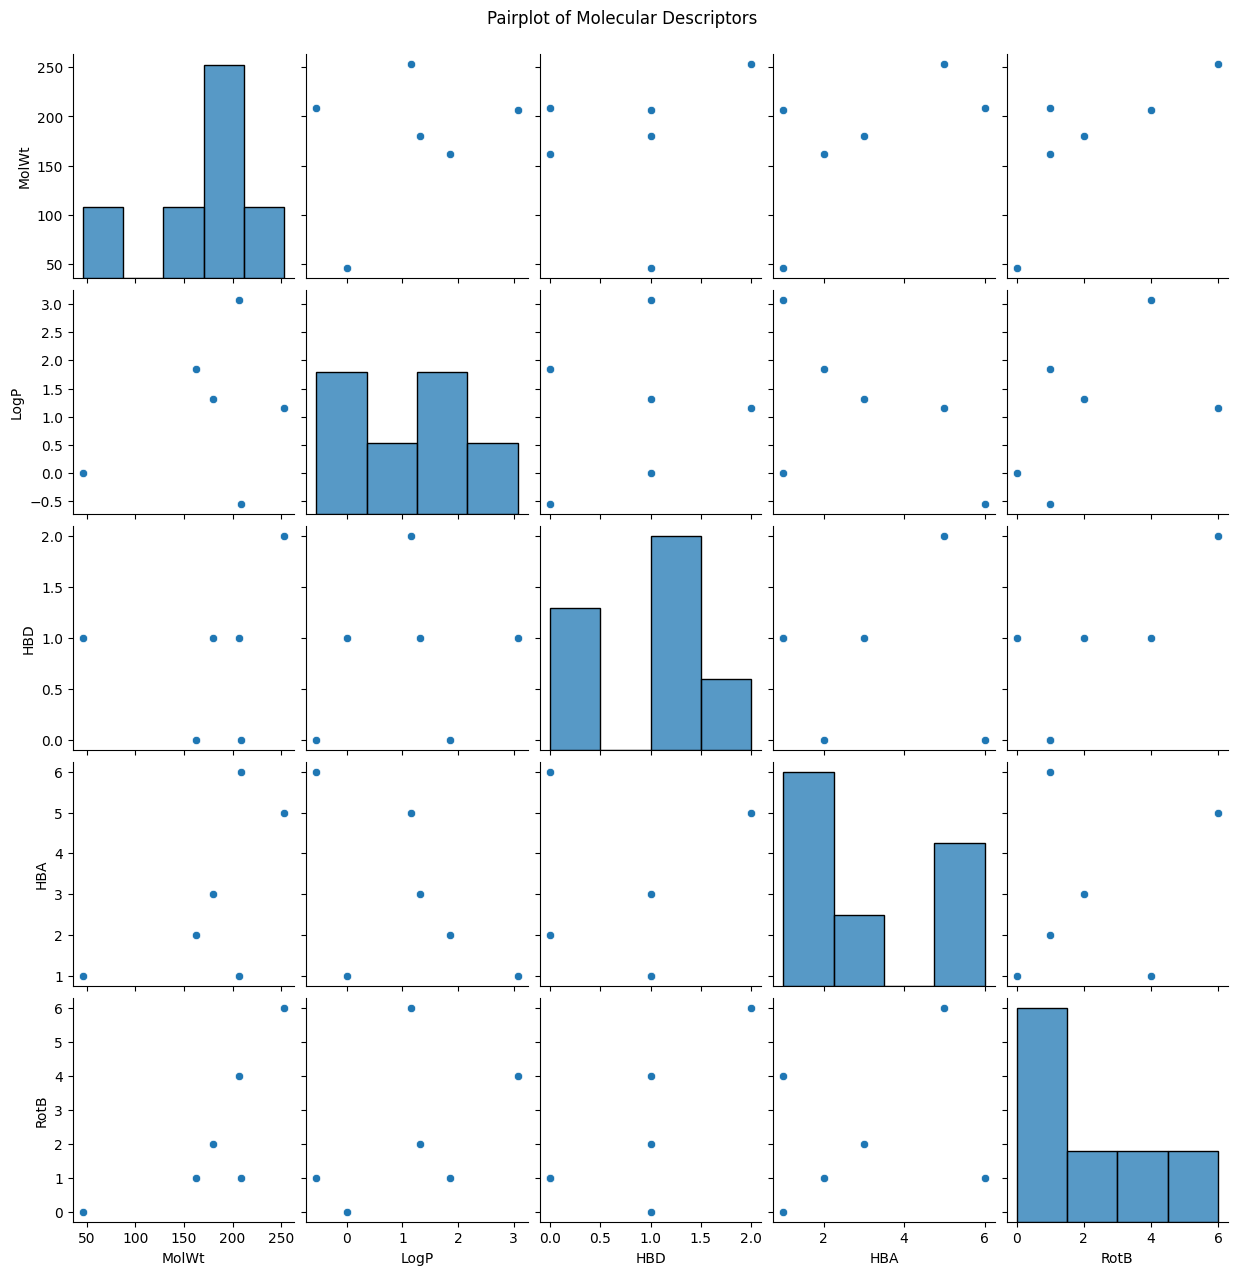

In [6]:
sns.pairplot(desc_data.drop("Name", axis=1))
plt.suptitle("Pairplot of Molecular Descriptors", y=1.02)
plt.show()

Step 7. Chemical Space Visualization (PCA)

Reduce dimensions to 2D for visualization.

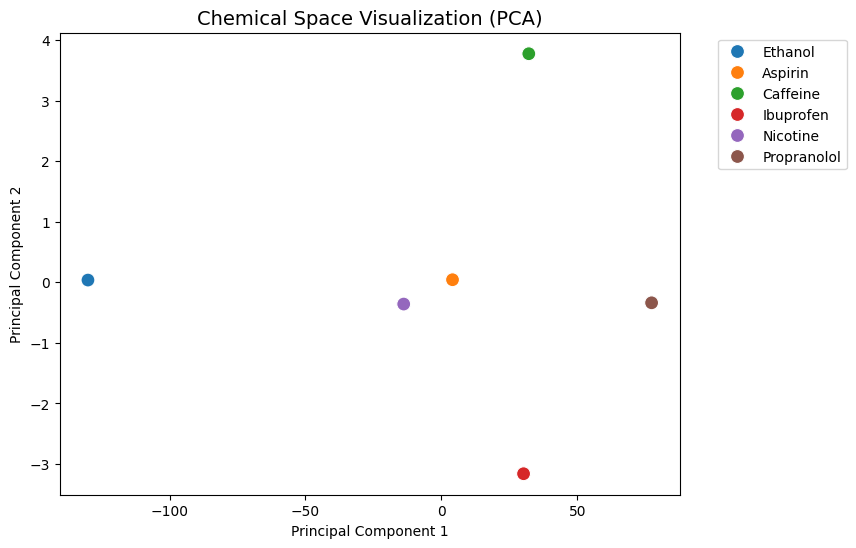

In [7]:
# PCA on descriptors
X = desc_df.values
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# Store results
desc_data["PC1"] = pca_result[:, 0]
desc_data["PC2"] = pca_result[:, 1]

# Scatter plot
plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", data=desc_data, hue="Name", s=100)
plt.title("Chemical Space Visualization (PCA)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

✅ Now we have:

	1.	Molecules → Descriptors
	2.	Pairplot of descriptors
	3.	2D Chemical Space Visualization using PCA

Interpretation of PCA plot:

	•	Ethanol (blue, far left) → isolated because it’s tiny (low MW, low rotatable bonds, low LogP).
	•	Ibuprofen & Propranolol → cluster on the right (heavier, more flexible, hydrophobic drugs).
	•	Caffeine (top) → separated due to unique structure (many heteroatoms, aromatic rings).
	•	Nicotine & Aspirin → more central (moderate size & polarity).

 PCA shows clustering & diversity in chemical space:

	•	Close molecules = similar descriptor profiles.
	•	Far molecules = chemically different.


 Lipinski’s Rule of Five (Drug-likeness criteria)

A molecule is considered likely to be orally bioavailable if it does NOT violate more than 1 rule:

	1.	Molecular weight (MolWt) ≤ 500
	2.	LogP ≤ 5
	3.	Hydrogen bond donors (HBD) ≤ 5
	4.	Hydrogen bond acceptors (HBA) ≤ 10

In [8]:
def lipinski_check(row):
    violations = 0
    if row["MolWt"] > 500:
        violations += 1
    if row["LogP"] > 5:
        violations += 1
    if row["HBD"] > 5:
        violations += 1
    if row["HBA"] > 10:
        violations += 1

    return {"Violations": violations,
            "Pass_Rule": "Yes" if violations <= 1 else "No"}


In [9]:
# Apply Lipinski check
lipinski_results = desc_data.apply(lipinski_check, axis=1, result_type="expand")

In [10]:
# Merge with descriptor data
final_data = pd.concat([desc_data, lipinski_results], axis=1)
final_data

,Name,MolWt,LogP,HBD,HBA,RotB,PC1,PC2,Violations,Pass_Rule
0,Ethanol,46.069,-0.0014,1,1,0,-130.012279,0.037768,0,Yes
1,Aspirin,180.159,1.3101,1,3,2,4.105556,0.043329,0,Yes
2,Caffeine,208.221,-0.5464,0,6,1,32.171978,3.775134,0,Yes
3,Ibuprofen,206.285,3.0732,1,1,4,30.240669,-3.160051,0,Yes
4,Nicotine,162.236,1.8483,0,2,1,-13.850889,-0.358426,0,Yes
5,Propranolol,253.298,1.1530,2,5,6,77.344966,-0.337754,0,Yes


 Interpretation:

	•	All six molecules pass Lipinski’s Rule (0 violations).
	•	Meaning they are all potentially orally bioavailable.
	•	This is just a first filter — real drug discovery also considers permeability, metabolism, toxicity, etc.

⸻

 This integrates pharmacokinetic relevance into our pipeline.